<a href="https://colab.research.google.com/github/eduardofae/RL/blob/main/AT-10/10%20-%20REINFORCE%20CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## REINFORCE
---
O algoritmo **REINFORCE** ([Williams, 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf)) é uma versão do gradiente de política em RL.

O agente coleta a trajetória de um episódio com a política atual.

Normalmente, esta política depende de um conjunto de parâmetros denotado por $\theta$. Neste colab, os parâmetros são os pesos de uma rede neural.

## Tarefa de Programação: Implementação e Ajuste do REINFORCE

Nesta tarefa, vocês irão trabalhar com a implementação do algoritmo REINFORCE para resolver um ambiente de controle clássico no Gymnasium. O objetivo é entender como a arquitetura da rede neural e a escolha dos hiperparâmetros afetam o desempenho do agente.

Vocês devem:

1.  **Analisar o código fornecido:** Familiarizem-se com as classes `PolicyNet`, a função `compute_returns` e as funções de treinamento (`train`) e avaliação (`evaluate_policy`).
2.  **Definir a arquitetura da rede neural:** Modifiquem a classe `PolicyNet` para experimentar diferentes arquiteturas da rede. Justifiquem suas escolhas.
3.  **Ajustar os hiperparâmetros:** Experimentem diferentes valores para os seguintes hiperparâmetros na célula:
    *   `GAMMA`: Fator de desconto para os retornos.
    *   `LR`: Taxa de aprendizado do otimizador Adam.
    *   `HIDDEN_SIZE`: Número de neurônios na(s) camada(s) oculta(s) da rede neural.
6.  **Documentar e analisar os resultados:** Registre as diferentes configurações testadas e os resultados obtidos. Analise como as mudanças na arquitetura e nos hiperparâmetros impactaram a velocidade de aprendizado e o desempenho final do agente.
4.  **Analisar a melhor configuração de hiperparâmetros:**  execute 10 repetições (treino/avaliação) de 1000 episódios da sua melhor configuração de hiperparâmetros. As repetições devem ser com sementes aleatórias diferentes, para avaliar a robustez da sua configuração. Plote gráficos 'sombreados' de recompensa ao longo do treinamento  (veja um exemplo abaixo e um guia no Item 2 [aqui](https://rll.berkeley.edu/deeprlcoursesp17/docs/plotting_handout.pdf)). Perceba as flutuações de desempenho (ou sua ausência). <img src='https://learn2learn.net/assets/img/examples/cheetah_fwdbwd_rewards.png' height="300"/>.
5. **Responder às perguntas propostas**: escreva nas células de texto as respostas às questões pedidas.
5.  **Experimentar com diferentes ambientes (Opcional):** O código está configurado para o ambiente 'CartPole-v1'. Vocês podem tentar aplicar o REINFORCE a outros ambientes clássicos do Gymnasium, como 'Acrobot-v1' ou 'MountainCar-v0', ajustando a arquitetura da rede e os hiperparâmetros conforme necessário. **Nota:** Lembrem-se de ajustar `SOLVED_SCORE` na célula de constantes se mudarem de ambiente.

**Entrega**

**IMPORTANTE**: você pode experimentar diferentes números de episódios de treinamento, mas não pode usar mais de 1000 episódios para os seus resultados finais.


## Ambiente CartPole-v1

O ambiente **CartPole-v1** é um ambiente clássico do **Gymnasium** (anteriormente OpenAI Gym) e é frequentemente usado como um exemplo introdutório para algoritmos de aprendizado por reforço.

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" height="150"/>

**Descrição:**

*   **Objetivo:** O objetivo é manter um poste (pêndulo) em pé em cima de um carrinho que se move horizontalmente.
*   **Estado:** O estado do ambiente é representado por quatro valores:
    1.  Posição do carrinho.
    2.  Velocidade do carrinho.
    3.  Ângulo do poste em relação à vertical.
    4.  Velocidade angular do poste.
*   **Ações:** O agente pode tomar duas ações discretas:
    *   Empurrar o carrinho para a esquerda.
    *   Empurrar o carrinho para a direita.
*   **Recompensa:** O agente recebe uma recompensa de +1 a cada passo de tempo em que o poste permanece em pé.
*   **Fim do Episódio:** Um episódio termina quando:
    *   O poste cai além de um certo ângulo.
    *   O carrinho se move para fora dos limites da tela.
    *   O episódio atinge um certo número máximo de passos de tempo (geralmente 500 para a versão v1).

O desafio é aprender uma política que, dadas as informações de estado (posição, velocidade, ângulo, velocidade angular), escolha a ação (empurrar para a esquerda ou direita) que maximize a recompensa total ao longo do tempo, mantendo o poste equilibrado.

## Utilitários

In [1]:
#@title Instalação de libs necessárias
!pip install gymnasium torch matplotlib pyvirtualdisplay --quiet

In [2]:
#@title Imports
import os
import time
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display


In [3]:
#@title Constantes
ENV_NAME = 'CartPole-v1'
PRINT_EVERY = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOLVED_SCORE = 475

In [4]:
#@title Semente para reprodutibilidade

def set_seed(env, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)

In [5]:
# @title Gravar e reproduzir video

from pyvirtualdisplay import Display

"""
Utility functions to enable video recording of gym environment
and displaying it.
"""
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

def record_and_display_video(env_name, policy_model, video_name, num_episodes=1):
    """
    Records a video of the agent performing in the environment and displays it.

    Args:
        env_name (str): The name of the environment.
        policy_model (torch.nn.Module): The trained PyTorch policy model.
        video_name (str): The name to use for the video file.
        num_episodes (int): The number of episodes to record (default is 1).
    """
    # create the directory to store the video(s)
    os.makedirs("./video", exist_ok=True)

    # Use a virtual display for rendering
    # display = Display(visible=False, size=(1400, 900))
    # _ = display.start()

    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env,
        video_folder="video",
        name_prefix=f"{env_name}_{video_name}",
        episode_trigger=lambda episode_id: episode_id < num_episodes
    )

    observation, _ = env.reset()
    total_reward = 0
    done = False
    episode_count = 0

    while not done:
        # Use the PyTorch model to get the action
        with torch.no_grad():
            obs_t = torch.tensor(observation, dtype=torch.float32, device=DEVICE).unsqueeze(0) # Add batch dimension
            probs = policy_model(obs_t)
            action = torch.argmax(probs).item() # Select action with highest probability

        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        if done:
            episode_count += 1
            if episode_count < num_episodes:
                observation, _ = env.reset()
                done = False


    env.close()
    # display.stop() # Stop the virtual display

    if PRINT_EVERY != -1: print(f"\nTotal reward: {total_reward}")

    # show video
    video_path = f"video/{env_name}_{video_name}-episode-0.mp4"
    if os.path.exists(video_path):
        html = render_mp4(video_path)
        return (total_reward, HTML(html))
    else:
        print(f"Video file not found: {video_path}")
        return (total_reward, None)

## Implementação do REINFORCE

A rede padrão fornecida na política não tem camadas ocultas. Para adicionar, use nn.Linear extras. É necessário adicionar uma ativação entre camadas (e.g. nn.ReLU ou nn.Sigmoid), caso contrário as camadas ocultas não tem efeito.

In [6]:
#@title Política - π(a|s; θ) - implementada por rede neural

class PolicyNet(nn.Module):
    def __init__(self, obs_size, n_actions, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            # Use Softmax para garantir que as saídas sejam probabilidades que
            # somam 1, representando a distr. de probabilidades sobre as ações.
            # A última dimensão (-1) corresponde aos logits das ações, pq o
            # tensor dentro da rede pode ter a forma [batch_size, n_actions]
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

### Cálculo dos retornos descontados

Calcula os retornos descontados a partir do vetor de recompensas do episódio

In [7]:
# ---------------------------
# Função para calcular retornos descontados G_t
# ---------------------------
def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    # Normalização (ajuda na estabilidade)
    returns = (returns - returns.mean()) / (returns.std(unbiased=False) + 1e-8)
    return returns

## Treinamento e avaliação

In [8]:
#@title Treinamento REINFORCE
def train(max_episodes, random_seed):
    env = gym.make('CartPole-v1')
    set_seed(env, random_seed)

    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy = PolicyNet(obs_size, n_actions, HIDDEN_SIZE).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)

    all_rewards = []
    mean_rewards = []
    recent_rewards = deque(maxlen=100)

    for episode in range(1, max_episodes + 1):
        obs, info = env.reset()
        obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)

        log_probs = []
        rewards = []
        done = False
        ep_reward = 0

        while not done:
            probs = policy(obs)
            dist = Categorical(probs)
            action = dist.sample()

            next_obs, reward, terminated, truncated, info = env.step(action.item())
            done = terminated or truncated

            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            ep_reward += reward

            obs = torch.tensor(next_obs, dtype=torch.float32, device=DEVICE)

        all_rewards.append(ep_reward)
        recent_rewards.append(ep_reward)

        # Compute returns e perda
        returns = compute_returns(rewards, GAMMA)
        log_probs_tensor = torch.stack(log_probs)

        loss = - (log_probs_tensor * returns).sum()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_recent = np.mean(recent_rewards)
        mean_rewards.append(mean_recent)

        if PRINT_EVERY != -1 and (episode % PRINT_EVERY == 0 or episode == 1):
            print(f"Ep {episode:4d} | Reward: {ep_reward:6.1f} | Média(100): {mean_recent:6.2f} | Loss: {loss.item():.3f}")

        if mean_recent >= SOLVED_SCORE and episode >= 100:
            if PRINT_EVERY != -1: print(f"\n✅ Ambiente resolvido em {episode} episódios! Média(100) = {mean_recent:.2f}")
            break

    env.close()
    return episode, policy, all_rewards, mean_rewards

In [9]:
#@title Avaliação
def evaluate_policy(policy, episodes=10):
    env = gym.make(ENV_NAME, render_mode=None)
    set_seed(env, SEED)
    rewards_eval = []

    for ep in range(episodes):
        obs, info = env.reset()
        done = False
        ep_reward = 0

        while not done:
            with torch.no_grad():
                obs_t = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
                probs = policy(obs_t)
                action = torch.argmax(probs).item()
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_reward += reward

        rewards_eval.append(ep_reward)

    env.close()
    return np.mean(rewards_eval), np.std(rewards_eval)

# Configuração e execução

In [10]:
#@title Salva arquivos no Drive (Opcional)
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab/AT-10 - REINFORCE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/AT-10 - REINFORCE


In [11]:
#@title Hiperparâmetros e configs
# Final Values      # Initial Values
SEED = 42           # 42
NUM_EPISODES = 1000 # 1000
GAMMA = 0.9         # 0.5
LR = 0.005          # 0.0001
HIDDEN_SIZE = 32    # 4

PRINT_EVERY = 10

## Execução Única

Ep    1 | Reward:   16.0 | Média(100):  16.00 | Loss: 0.184
Ep   10 | Reward:   13.0 | Média(100):  23.00 | Loss: -0.238
Ep   20 | Reward:   19.0 | Média(100):  22.05 | Loss: 0.245
Ep   30 | Reward:   14.0 | Média(100):  22.77 | Loss: -0.885
Ep   40 | Reward:   23.0 | Média(100):  22.02 | Loss: -0.077
Ep   50 | Reward:   15.0 | Média(100):  24.52 | Loss: 2.196
Ep   60 | Reward:   91.0 | Média(100):  29.85 | Loss: -7.923
Ep   70 | Reward:  149.0 | Média(100):  36.93 | Loss: -1.309
Ep   80 | Reward:  294.0 | Média(100):  56.56 | Loss: 2.370
Ep   90 | Reward:  500.0 | Média(100):  87.82 | Loss: -0.787
Ep  100 | Reward:  500.0 | Média(100): 129.00 | Loss: 2.166
Ep  110 | Reward:   16.0 | Média(100): 147.67 | Loss: -1.319
Ep  120 | Reward:   18.0 | Média(100): 150.47 | Loss: -2.124
Ep  130 | Reward:  283.0 | Média(100): 163.23 | Loss: 2.814
Ep  140 | Reward:  324.0 | Média(100): 202.54 | Loss: 3.795
Ep  150 | Reward:  187.0 | Média(100): 221.95 | Loss: -4.629
Ep  160 | Reward:  161.0 | Médi

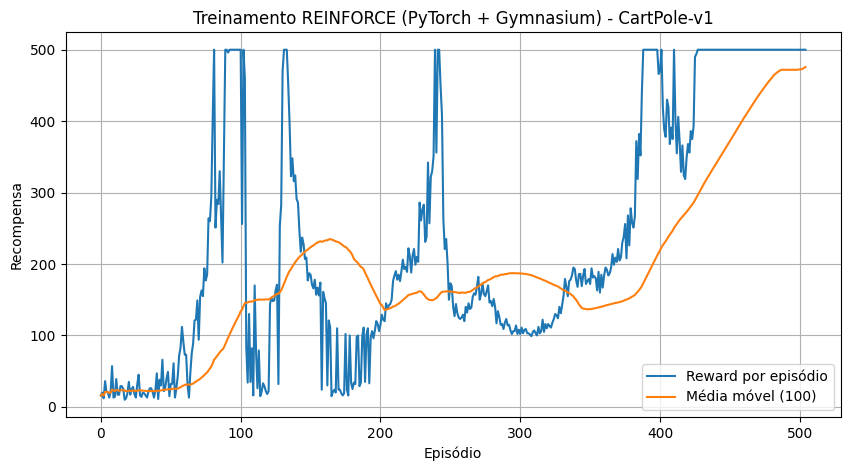

Modelo salvo em: policy_reinforce_cartpole.pt


In [12]:
#@title Execução de treinamento e avaliação
start_time = time.time()
episodes, policy, all_rewards, mean_rewards = train(NUM_EPISODES, SEED)
train_time = time.time() - start_time

print(f"\nTreinamento concluído em {train_time:.1f}s")
mean_eval, std_eval = evaluate_policy(policy, 20)
print(f"Avaliação: média = {mean_eval:.2f} ± {std_eval:.2f} (20 episódios)")

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(all_rewards, label="Reward por episódio")
plt.plot(mean_rewards, label="Média móvel (100)")
plt.xlabel("Episódio")
plt.ylabel("Recompensa")
plt.title("Treinamento REINFORCE (PyTorch + Gymnasium) - CartPole-v1")
plt.legend()
plt.grid(True)
plt.show()

torch.save(policy.state_dict(), "policy_reinforce_cartpole.pt")
print("Modelo salvo em: policy_reinforce_cartpole.pt")

In [13]:
#@title Visualiza execução
total_reward, video = record_and_display_video(ENV_NAME, policy, "after-training")
video

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Colab/AT-10 - REINFORCE/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Total reward: 500.0


In [14]:
#@title Salva execução
import json
import os
file_path = 'executions.json'

results = {}
if os.path.exists(file_path):
    results = json.loads(open(file_path, 'r').read())
results[f'{GAMMA}-{LR}-{HIDDEN_SIZE}'] = {
    'params': {
        'gamma': GAMMA,
        'lr': LR,
        'hidden_size': HIDDEN_SIZE
    },
    'results' : {
        'total': total_reward,
        'mean': mean_eval,
        'std': std_eval,
        'episodes': episodes
    }
}
open(file_path, 'w').write(json.dumps(results))

298

## Execução Automatizada do Teste de Parâmetros (RECOMENDADO PULAR)

In [15]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [16]:
%%skip # Pula essa célula (comentar caso queira executar)
#@title Automatização dos testes de Parâmetros
from pathlib import Path
def train_eval():
    episodes, policy, all_rewards, mean_rewards = train(NUM_EPISODES, SEED)
    mean_eval, std_eval = evaluate_policy(policy, 20)
    policy_path = Path(f"policies/{GAMMA}/{LR}/{HIDDEN_SIZE}/policy_reinforce_cartpole.pt")
    policy_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(policy.state_dict(), policy_path)
    video_path = Path(f"video/CartPole-v1_/{GAMMA}/{LR}/{HIDDEN_SIZE}")
    video_path.mkdir(parents=True, exist_ok=True)
    total_reward, _ = record_and_display_video(ENV_NAME, policy, f"/{GAMMA}/{LR}/{HIDDEN_SIZE}/after-training")
    return episodes, total_reward, mean_eval, std_eval

gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lrs = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
hss = [2, 4, 8, 16, 32]
PRINT_EVERY = -1

import csv
from tqdm.notebook import tqdm
file_path = 'results.csv'
results = []
it1 = tqdm(gammas)
for GAMMA in it1:
    it1.set_postfix({'gamma': GAMMA})
    it2 = tqdm(lrs, leave=False)
    for LR in it2:
        it3 = tqdm(hss, leave=False)
        it2.set_postfix({'learning_rate': LR})
        for HIDDEN_SIZE in it3:
            it3.set_postfix({'hidden_layers_size': HIDDEN_SIZE})
            episodes, total_reward, mean_eval, std_eval = train_eval()
            results.append({
                'gamma': GAMMA,
                'lr': LR,
                'hidden_size': HIDDEN_SIZE,
                'total': total_reward,
                'mean': mean_eval,
                'std': std_eval,
                'episodes': episodes
            })
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

## Execução Modelo Final

In [17]:
#@title Hiperparâmetros e configs
NUM_EPISODES = 1000
GAMMA = 0.9
LR = 0.005
HIDDEN_SIZE = 32

PRINT_EVERY = -1
SOLVED_SCORE = 501

In [18]:
from tqdm.notebook import tqdm
import time
MIN_SEED, MAX_SEED = 0, 2**32 - 1
np.random.seed(int(time.time()))
seeds = np.random.randint(MIN_SEED, MAX_SEED, size=10)
all_runs = []
for SEED in tqdm(seeds):
    _, _, all_rewards, _ = train(NUM_EPISODES, int(SEED))
    all_runs.append(all_rewards)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# SEEDS GERADAS UTILIZADAS NO GRÁFICO:
# [4285185521, 8749313, 2767812160, 3144983413, 2425574663, 95955093, 816964609, 3311519525, 2791483487, 94941631]
seeds

array([4285185521,    8749313, 2767812160, 3144983413, 2425574663,
         95955093,  816964609, 3311519525, 2791483487,   94941631])

Final Mean: 166.30
Final Std: 133.93


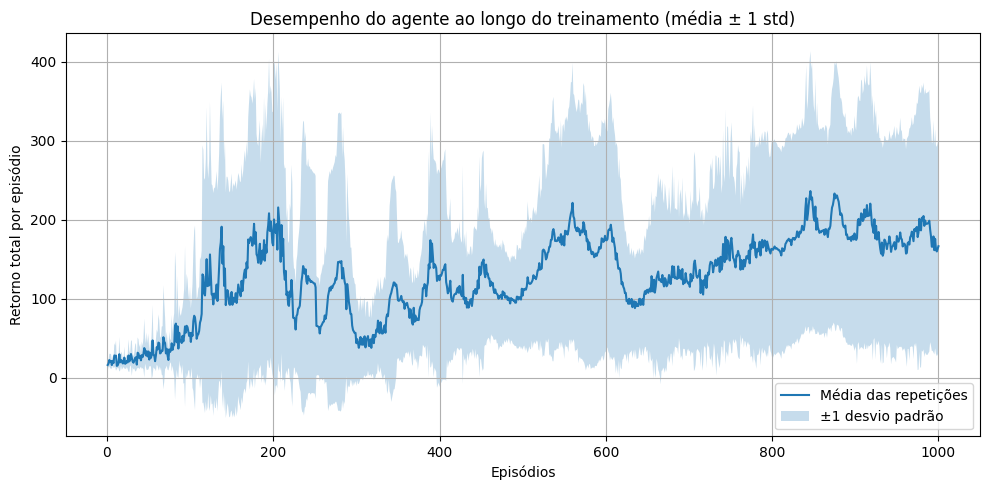

In [20]:
import matplotlib.pyplot as plt
import numpy as np

all_runs = np.vstack(all_runs)
mean_rewards = all_runs.mean(axis=0)
std_rewards = all_runs.std(axis=0)

episodes = np.arange(1, NUM_EPISODES + 1)

print(f'Final Mean: {mean_rewards[-1]:.2f}')
print(f'Final Std: {std_rewards[-1]:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(episodes, mean_rewards, label='Média das repetições')
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.25, label='±1 desvio padrão')
plt.xlabel('Episódios')
plt.ylabel('Retorno total por episódio')
plt.title('Desempenho do agente ao longo do treinamento (média ± 1 std)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Questões:

* Por que o sinal negativo é usado no cálculo da loss em PyTorch?

* O que acontece com o aprendizado se a normalização de retornos é removida  (returns = (returns - mean)/std).?

* Por que é importante que a política retorne uma distribuição de probabilidade em vez de uma ação determinística?

* O que você observou ao testar redes menores ou maiores?

* Como a taxa de aprendizado afeta a convergência e a estabilidade do treinamento?

* Discuta a robustez da sua melhor configuração: Houve grande variação entre execuções com sementes diferentes? O que isso indica sobre a variância do gradiente no REINFORCE?

Feedback:
* Qual parte da tarefa foi mais desafiadora para você?

* O que ficou mais claro sobre o funcionamento do REINFORCE após essa atividade?

* Há algo que você mudaria na estrutura da tarefa para torná-la mais didática?

#Configuração Escolhida
1. Número de camadas ocultas: Foram utilizadas 3 camadas ocultas, pois, durante os testes iniciais, 3 camadas se demonstraram eficientes em termos de resultados obtidos e tempo requerido.

2. Os valores de Gamma testados foram:
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]. No geral, quanto maior o Gamma melhores foram os resultados, com apenas valores superiores a 0.5 (incluso) sendo capazes de resolver o ambiente.

3. Os valores de Learning Rate testados foram:
[0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]. No geral, quanto maior o Learning Rate, mais rápida, porém menos estável é a convergência. Valores abaixo de 0.001 pareceram ser muito baixos para 1000 episódios, com alguns casos isolados apresentando bons resultados. Valores muito altos também apresentaram problemas na convergência em casos específicos.

4. Os valores de Hidden Layers Size testados foram:
[2, 4, 8, 16, 32]. Este parâmetro é uma faca de dois gumes, apresentando bons resultados quando aumentado, contudo é também o parâmetro mais custoso computacionalmente. Além disso, quando utilizamos Learning Rates muito grandes, com HLSs altos, o modelo sofre muito com instabilidades na convergência.

**As 3 configurações que derrotaram o ambiente com o menor número de episódios foram:**

- **1. Gamma: 0.8, LR: 0.05, HLS: 4. (Levando 408 episódios)**
- **2. Gamma: 0.6, LR: 0.005, HLS: 32. (Levando 457 episódios)**
- **3. Gamma: 0.9, LR: 0.005, HLS: 32. (Levando 505 episódios)**
- Seed utilizada nessa etapa: 42.

**Essas 3 configurações passaram pela etapa de teste de robustez, onde cada uma rodou com 10 seeds (geradas aleatoriamente mas mantidas entre execução) e suas médias e desvios padrões finais estão expressos abaixo:**
- **1. Mean: 139.30, Std: 199.64.**
- **2. Mean: 181.60, Std: 151.24.**
- **3. Mean: 188.00, Std: 166.38.**

- Seeds utilizadas nessa etapa:
    - 2746317213, 1181241943, 958682846, 3163119785, 1812140441, 127978094, 939042955, 2340505846, 946785248, 2530876844.

**Assim, a configuração final escolhida foi:**
- **Gamma: 0.9, LR: 0.005, HLS: 32.**

Uma célula que executa os testes com cada conjunto de parâmetros e guarda (em um csv) os resultados obtidos foi disponibilizada aos interessados em executá-la. (tempo estimado de execução: 3/4 horas)

Além disso os resultados obtidos estão disponíveis me uma planilha no [link](https://docs.google.com/spreadsheets/d/1AWN2hF9diV7YroC8_3tUT0R-l1SJ2V2tRJtT8yvpi6c/edit?usp=sharing).

#Questões
1. PyTorch faz uso de gradiente descendente. Por esse motivo é necessário o uso do sinal negativo, a fim de converter tarefas de maximização (como é o caso do REINFORCE) para o escopo de minimização.

2. Com a normalização de retornos removida, o aprendizado fica mais lento e instável, já que a escala e a variação das recompensas terão um impacto direto no desempenho.

3. A distribuição de probabilidade é importante para permitir que o agente realize exploração, não apenas explotação.

4. Redes maiores produzem resultados melhores, porém apresentam tempos de treinamento significativamente maiores.

5. Learning rates maiores aceleraram a velocidade de conversão, mas diminuíram a estabilidade do treinamento. Quando o learning rate é muito alto (acima de 0.01) os resultados obtidos ocilam muito, gerando modelos piores.

6. Sim, houve uma grande variação entre execuções com sementes diferentes. O que indica que o REINFORCE tem alta variância no gradiente. Isso acontece, pois o mesmo usa amostras aleatórias. Fazendo com que pequenas diferenças possam gerar trajetórias completamente diferentes, causando atualizações de peso completamente diferentes.

#Feedback
1. Nenhuma parte foi necessariamente desafiadora, a parte mais demorada definitivamente foi a execução dos testes de configuração.

2. Acredito que a aula/slides foram mais esclarecedores do que o trabalho em si, já que nada foi implementado diretamente no mesmo.

3. Creio que o foco em implementação, em detrimento ao fine-tuning de parâmetros, permita uma abordagem mais didática do tema.